CROP DISEASE DETECTION - EXPLORATORY DATA ANALYSIS
Exists? True

📁 Dataset Path: C:\Users\anask\crop-disease-detection\data\raw\plantvillage-dataset\plantvillage dataset\color
📊 Number of Classes: 38
Some classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy']

CLASS DISTRIBUTION

Total Images: 108608

Top 10 Classes by Count:
                                        Class  Count  Percentage
     Orange___Haunglongbing_(Citrus_greening)  11014       10.14
       Tomato___Tomato_Yellow_Leaf_Curl_Virus  10714        9.86
                            Soybean___healthy  10180        9.37
                       Peach___Bacterial_spot   4594        4.23
                      Tomato___Bacterial_spot   4254        3.92
                      

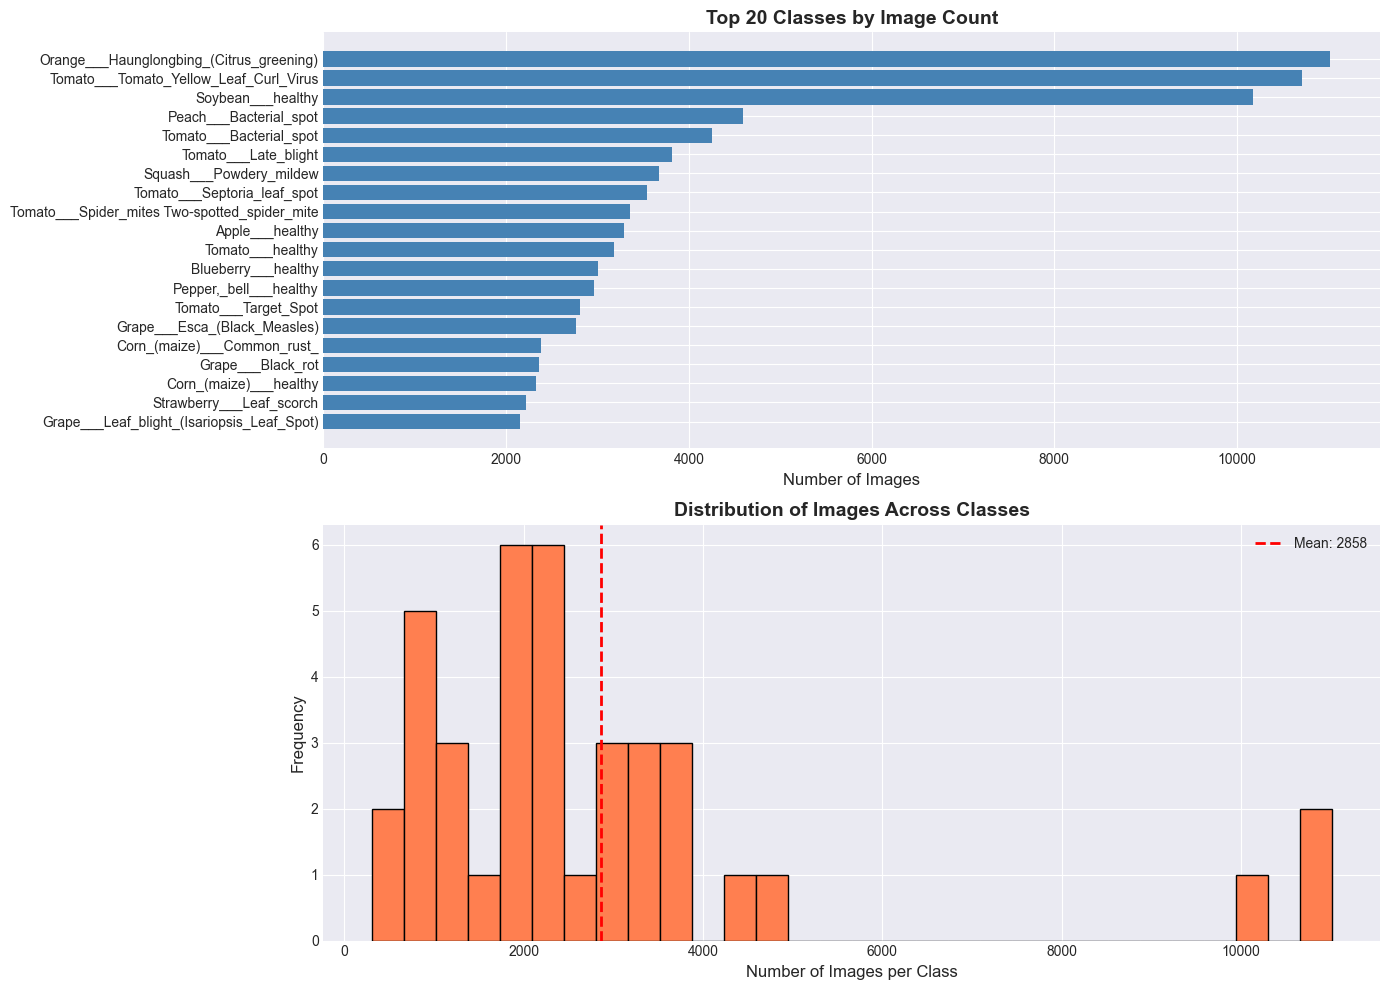

✅ Saved: results/plant_distribution.png


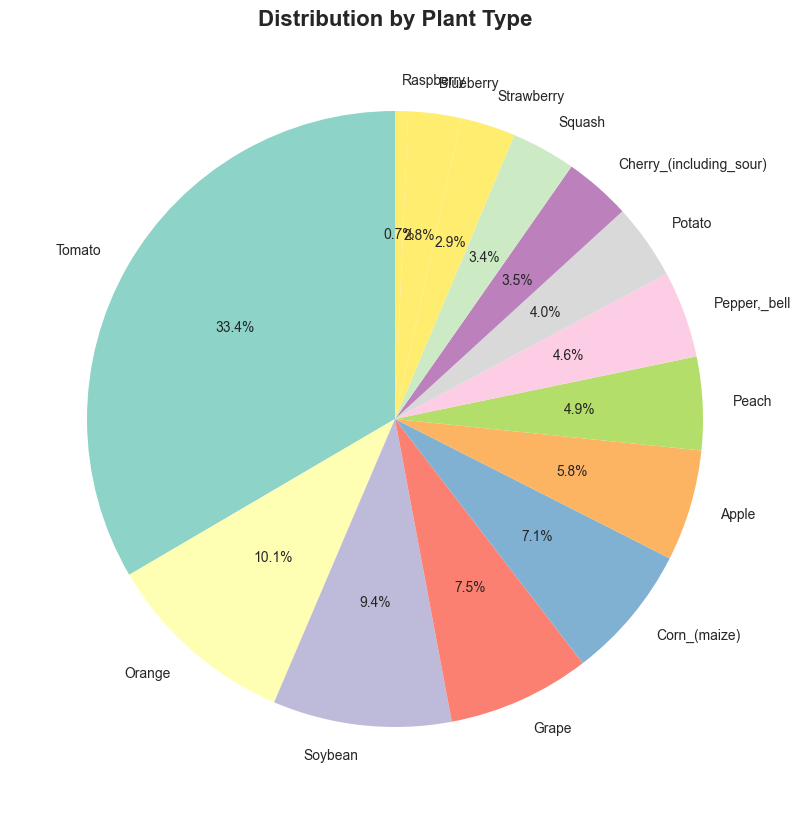


IMAGE PROPERTIES ANALYSIS

📸 Analyzed 100 sample images

Image Dimensions:
  Height - Mean: 256, Range: [256, 256]
  Width - Mean: 256, Range: [256, 256]
  Aspect Ratio - Mean: 1.00
  File Size - Mean: 15 KB

✅ Saved: results/image_properties.png


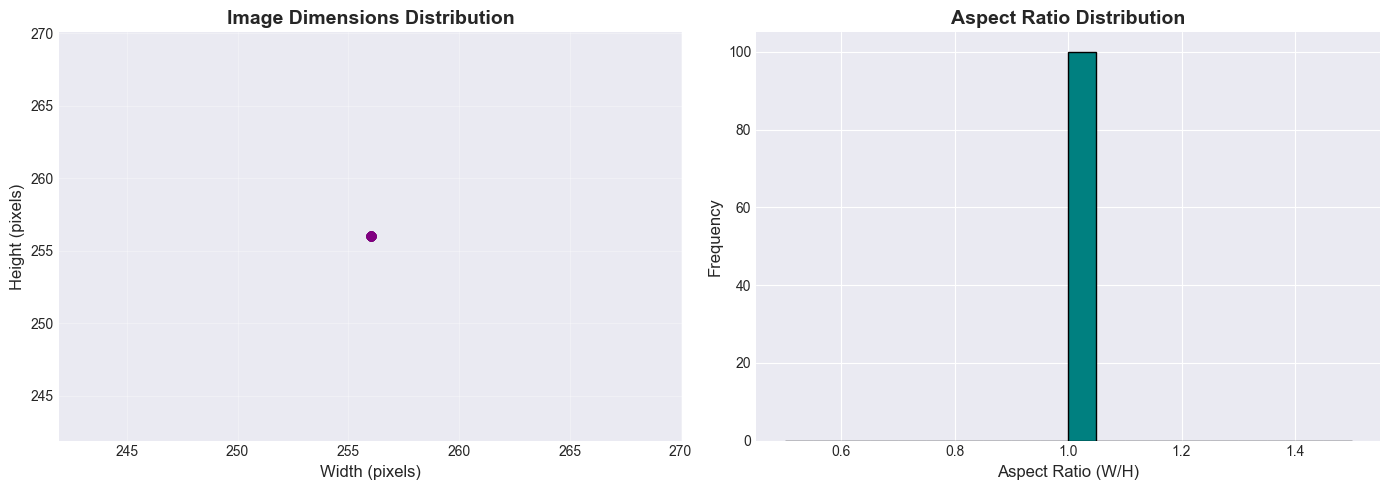


SAMPLE IMAGES VISUALIZATION
✅ Saved: results/sample_images.png


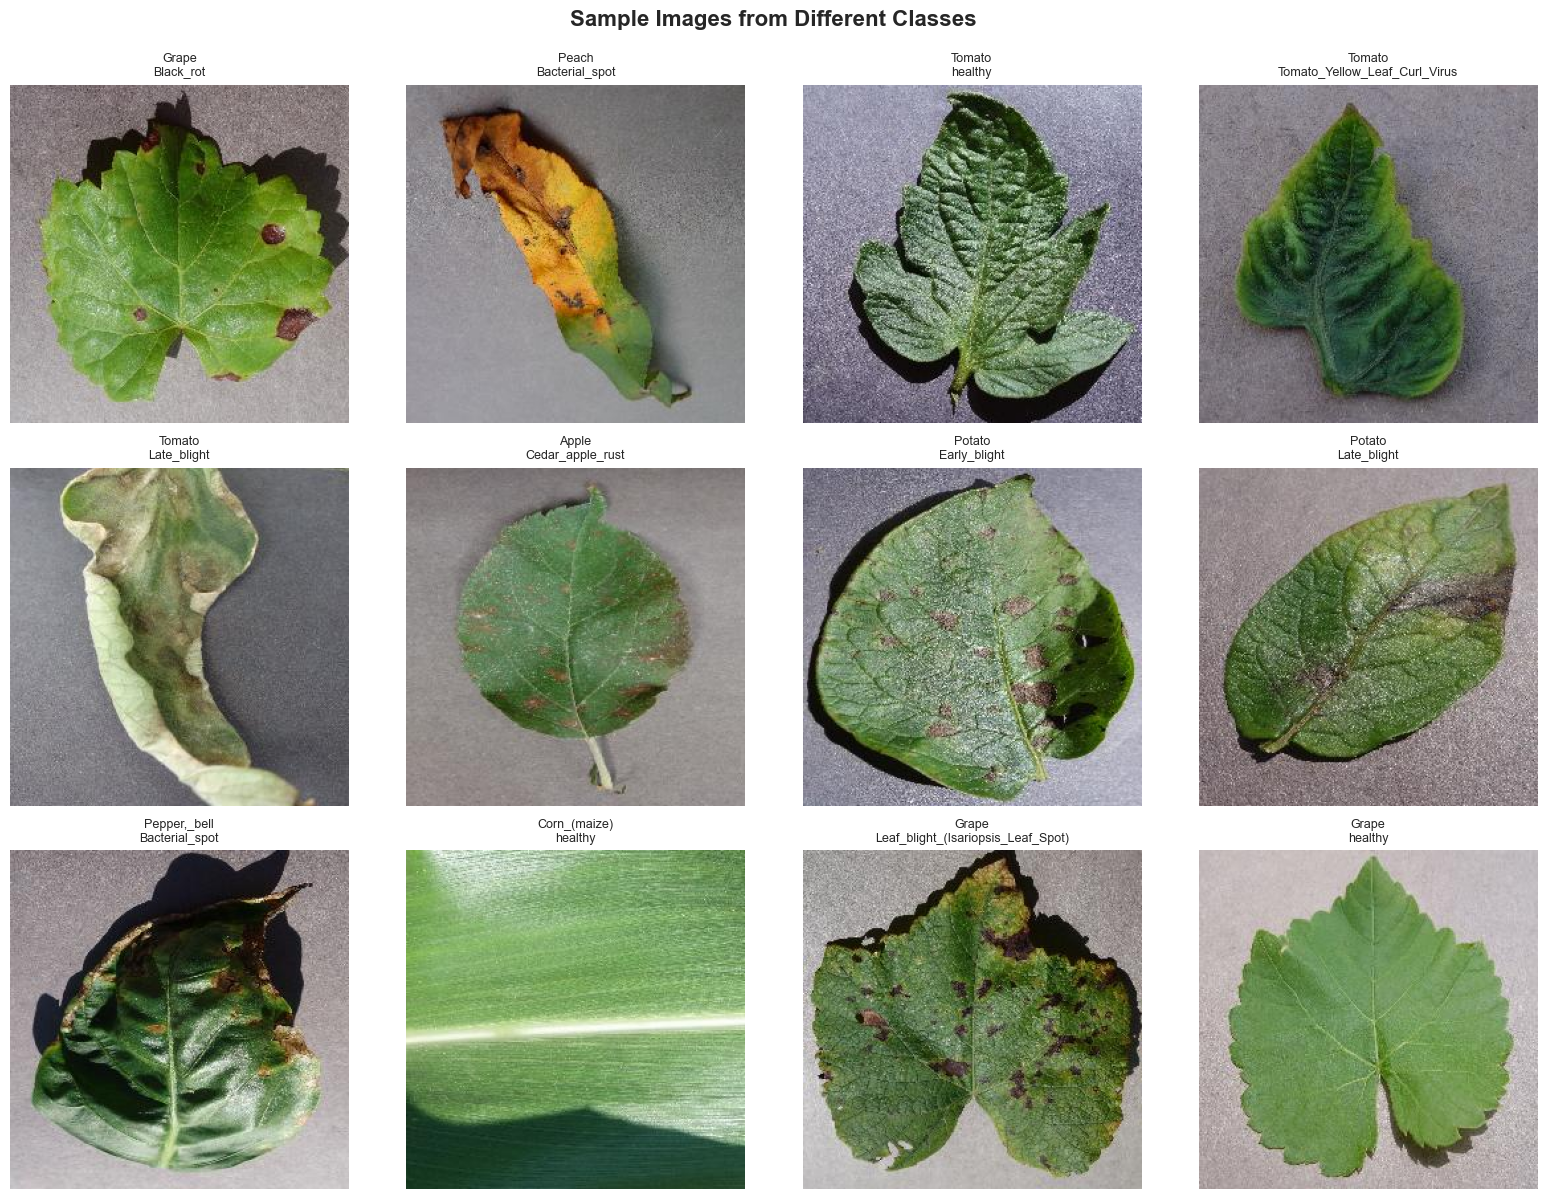


COLOR DISTRIBUTION ANALYSIS
✅ Saved: results/color_distribution.png


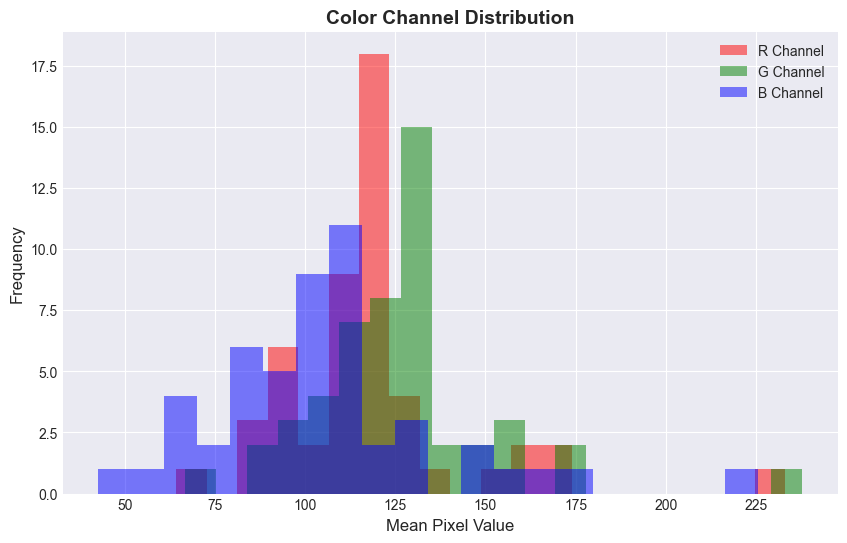


KEY INSIGHTS & RECOMMENDATIONS

✅ Dataset Characteristics:
  • 38 disease classes across multiple crop types
  • Total 108608 images available
  • Average 2858 images per class

⚠️  Potential Issues:
  • Class imbalance detected (ratio: 36.23)
  • Consider using class weights or data augmentation

💡 Recommendations:
  1. Use data augmentation to balance classes
  2. Resize all images to 224x224 or 256x256
  3. Apply normalization (0-1 scaling)
  4. Use stratified train/val/test split (70/15/15)
  5. Consider transfer learning with MobileNetV2 or EfficientNet

🎯 Next Steps:
  → Run data_loader.py to create train/val/test split
  → Proceed to 02_preprocessing.ipynb

EDA COMPLETE!


In [13]:
# %% [markdown]
# # 01 - Exploratory Data Analysis (EDA)
# This notebook analyzes the PlantVillage dataset before training

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %%
print("=" * 70)
print("CROP DISEASE DETECTION - EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Exact path to the color images folder
RAW_DATA_PATH = Path(r"C:/Users/anask/crop-disease-detection/data/raw/plantvillage-dataset/plantvillage dataset/color")

# Verify path exists
print("Exists?", RAW_DATA_PATH.exists())

# List all class directories
if RAW_DATA_PATH.exists():
    class_dirs = sorted([d for d in RAW_DATA_PATH.iterdir() if d.is_dir()])
    print(f"\n📁 Dataset Path: {RAW_DATA_PATH}")
    print(f"📊 Number of Classes: {len(class_dirs)}")
    print("Some classes:", [d.name for d in class_dirs[:10]])
else:
    print("❌ Path does not exist! Check folder names.")


# %% [markdown]
# ## 1. CLASS DISTRIBUTION ANALYSIS

# %%
print("\n" + "=" * 70)
print("CLASS DISTRIBUTION")
print("=" * 70)

# Collect class statistics
class_stats = []
for class_dir in class_dirs:
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG')) + \
             list(class_dir.glob('*.png')) + list(class_dir.glob('*.PNG'))
    
    class_stats.append({
        'Class': class_dir.name,
        'Count': len(images)
    })

df_classes = pd.DataFrame(class_stats)
df_classes = df_classes.sort_values('Count', ascending=False).reset_index(drop=True)
df_classes['Percentage'] = (df_classes['Count'] / df_classes['Count'].sum() * 100).round(2)

print(f"\nTotal Images: {df_classes['Count'].sum()}")
print(f"\nTop 10 Classes by Count:")
print(df_classes.head(10).to_string(index=False))

# %%
# Class distribution statistics
print(f"\n📊 Class Distribution Statistics:")
print(f"  Mean: {df_classes['Count'].mean():.0f}")
print(f"  Median: {df_classes['Count'].median():.0f}")
print(f"  Std Dev: {df_classes['Count'].std():.0f}")
print(f"  Min: {df_classes['Count'].min()}")
print(f"  Max: {df_classes['Count'].max()}")
print(f"  Imbalance Ratio: {df_classes['Count'].max() / df_classes['Count'].min():.2f}")

# %% [markdown]
# ## 2. VISUALIZATIONS

# %%
# Create results directory
Path('results').mkdir(exist_ok=True)

# %%
# 2.1 Class Distribution Bar Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 20 classes
top_20 = df_classes.head(20)
axes[0].barh(top_20['Class'], top_20['Count'], color='steelblue')
axes[0].set_xlabel('Number of Images', fontsize=12)
axes[0].set_title('Top 20 Classes by Image Count', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Distribution histogram
axes[1].hist(df_classes['Count'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Images per Class', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Images Across Classes', fontsize=14, fontweight='bold')
axes[1].axvline(df_classes['Count'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_classes["Count"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('results/class_distribution.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: results/class_distribution.png")
plt.show()

# %%
# 2.2 Pie Chart of Class Categories
plt.figure(figsize=(10, 10))

# Extract plant type from class name
df_classes['Plant'] = df_classes['Class'].apply(lambda x: x.split('___')[0] if '___' in x else x.split('_')[0])
plant_counts = df_classes.groupby('Plant')['Count'].sum().sort_values(ascending=False)

colors = plt.cm.Set3(range(len(plant_counts)))
plt.pie(plant_counts.values, labels=plant_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors)
plt.title('Distribution by Plant Type', fontsize=16, fontweight='bold')
plt.savefig('results/plant_distribution.png', dpi=150, bbox_inches='tight')
print("✅ Saved: results/plant_distribution.png")
plt.show()

# %% [markdown]
# ## 3. IMAGE PROPERTIES ANALYSIS

# %%
print("\n" + "=" * 70)
print("IMAGE PROPERTIES ANALYSIS")
print("=" * 70)

# Sample 100 images from random classes
sample_images = []
for class_dir in np.random.choice(class_dirs, min(10, len(class_dirs)), replace=False):
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
    if images:
        sample_images.extend(np.random.choice(images, min(10, len(images)), replace=False))

# Analyze image properties
image_props = []
for img_path in sample_images:
    img = cv2.imread(str(img_path))
    if img is not None:
        h, w, c = img.shape
        size_kb = img_path.stat().st_size / 1024
        image_props.append({
            'height': h,
            'width': w,
            'channels': c,
            'size_kb': size_kb,
            'aspect_ratio': w / h
        })

df_props = pd.DataFrame(image_props)

print(f"\n📸 Analyzed {len(df_props)} sample images")
print(f"\nImage Dimensions:")
print(f"  Height - Mean: {df_props['height'].mean():.0f}, Range: [{df_props['height'].min()}, {df_props['height'].max()}]")
print(f"  Width - Mean: {df_props['width'].mean():.0f}, Range: [{df_props['width'].min()}, {df_props['width'].max()}]")
print(f"  Aspect Ratio - Mean: {df_props['aspect_ratio'].mean():.2f}")
print(f"  File Size - Mean: {df_props['size_kb'].mean():.0f} KB")

# Visualize image dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_props['width'], df_props['height'], alpha=0.6, color='purple')
axes[0].set_xlabel('Width (pixels)', fontsize=12)
axes[0].set_ylabel('Height (pixels)', fontsize=12)
axes[0].set_title('Image Dimensions Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_props['aspect_ratio'], bins=20, color='teal', edgecolor='black')
axes[1].set_xlabel('Aspect Ratio (W/H)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/image_properties.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: results/image_properties.png")
plt.show()

# %% [markdown]
# ## 4. SAMPLE IMAGES VISUALIZATION

# %%
print("\n" + "=" * 70)
print("SAMPLE IMAGES VISUALIZATION")
print("=" * 70)

# Select 12 random classes
sample_classes = np.random.choice(class_dirs, min(12, len(class_dirs)), replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, class_dir in enumerate(sample_classes):
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
    if images:
        img_path = np.random.choice(images)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(class_dir.name.replace('___', '\n'), fontsize=9)
        axes[idx].axis('off')

plt.suptitle('Sample Images from Different Classes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/sample_images.png', dpi=150, bbox_inches='tight')
print("✅ Saved: results/sample_images.png")
plt.show()

# %% [markdown]
# ## 5. COLOR DISTRIBUTION ANALYSIS

# %%
print("\n" + "=" * 70)
print("COLOR DISTRIBUTION ANALYSIS")
print("=" * 70)

# Analyze color channels for sample images
color_stats = {'R': [], 'G': [], 'B': []}

for img_path in sample_images[:50]:  # Analyze 50 images
    img = cv2.imread(str(img_path))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        color_stats['R'].append(img[:,:,0].mean())
        color_stats['G'].append(img[:,:,1].mean())
        color_stats['B'].append(img[:,:,2].mean())

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'green', 'blue']
for channel, color in zip(['R', 'G', 'B'], colors):
    ax.hist(color_stats[channel], bins=20, alpha=0.5, label=f'{channel} Channel', color=color)

ax.set_xlabel('Mean Pixel Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Color Channel Distribution', fontsize=14, fontweight='bold')
ax.legend()
plt.savefig('results/color_distribution.png', dpi=150, bbox_inches='tight')
print("✅ Saved: results/color_distribution.png")
plt.show()

# %% [markdown]
# ## 6. KEY INSIGHTS & RECOMMENDATIONS

# %%
print("\n" + "=" * 70)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 70)

print("\n✅ Dataset Characteristics:")
print(f"  • {len(class_dirs)} disease classes across multiple crop types")
print(f"  • Total {df_classes['Count'].sum()} images available")
print(f"  • Average {df_classes['Count'].mean():.0f} images per class")

print("\n⚠️  Potential Issues:")
if df_classes['Count'].max() / df_classes['Count'].min() > 2:
    print(f"  • Class imbalance detected (ratio: {df_classes['Count'].max() / df_classes['Count'].min():.2f})")
    print(f"  • Consider using class weights or data augmentation")

print("\n💡 Recommendations:")
print("  1. Use data augmentation to balance classes")
print("  2. Resize all images to 224x224 or 256x256")
print("  3. Apply normalization (0-1 scaling)")
print("  4. Use stratified train/val/test split (70/15/15)")
print("  5. Consider transfer learning with MobileNetV2 or EfficientNet")

print("\n🎯 Next Steps:")
print("  → Run data_loader.py to create train/val/test split")
print("  → Proceed to 02_preprocessing.ipynb")

print("\n" + "=" * 70)
print("EDA COMPLETE!")
print("=" * 70)


In [22]:
from pathlib import Path

p = Path('data/raw/plantvillage-dataset')
print(list(p.glob('*')))  # This will list everything inside



[]
